# Assignment 6 - Reinforcement Learning
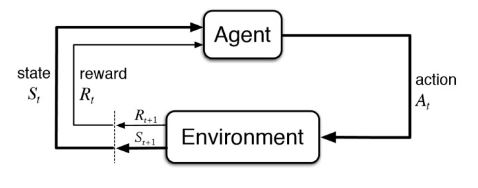

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Reinforcement learning** (RL) is a subset of machine learning which poses learning problems as interactions between agents and environments. It often assumes agents have no prior knowledge of the given world, so they must learn to navigate environments by optimizing some provided reward function.    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Within a world, an agent can take certain actions and receive feedback–in the form of positive or negative rewards–with respect to their decision. As such, an agent’s feedback loop is somewhat akin to the manner in which a child might learn to  distinguish between `“good”` and `“bad”` actions. In practical terms, our RL agent will interact with the environment by taking  an action at each time step, receiving a corresponding reward, and updating its state according to what it’s `“learned”`.    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In this lab, we focus on building a model-free reinforcement learning algorithm to master two different environments with varying complexity.

## Environment Preparation

In [ ]:
#Prepare the environment
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay scikit-video > /dev/null 2>&1

import tensorflow as tf
tf.enable_eager_execution()


import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import time

## Utils

In [ ]:
# Download the class repository
! git clone https://github.com/aamini/introtodeeplearning_labs.git  > /dev/null 2>&1
% cd introtodeeplearning_labs 
! git pull
% cd ..

!cp -r /content/introtodeeplearning_labs/lab1 lab1
!cp -r /content/introtodeeplearning_labs/lab1 lab2
!cp -r /content/introtodeeplearning_labs/lab1 lab3
!cp -r /content/lab1/util.py util.py

import introtodeeplearning_labs as util

env = gym.make("CartPole-v0")
env.seed(1) # reproducible, since RL has high variance

print ("Enviornment has observation space = {}".format(env.observation_space))

n_actions = env.action_space.n
print ("Number of possible actions that the agent can choose from = {}".format(n_actions))

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of $+1$ or $-1$ to the cart. The pendulum starts upright, and the goal is to prevent it from falling over.  A reward of $+1$ is provided for every time step that the pole remains upright. The episode ends when the pole is more than $15$ degrees from vertical, or the cart moves more than $2.4$ units from the center.

## Model Creation

In [ ]:
def create_cartpole_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(units=32, activation='relu'),
        # TODO: define the output dimension of the last Dense layer
        # Hint: think about that the space the agent needs to act in
        tf.keras.layers.Dense(units=n_actions, activation=None)
    ])
    return model

cartpole_model = create_cartpole_model()

### Comments
* Adding `L2-Regularization` helps convergence faster.
* Adding `CNN` takes a huge amount of time to give a significantly better accuracy.
* Adding more layers takes a significant time with a little improvement.

## Softmax Action

In [ ]:
def choose_action(model, observation):
    
    observation = observation.reshape([1, -1])
    '''TODO: feed the observations through the model to predict the log probabilities of each possible action.'''
    logits = model.predict(observation)
    
    # pass the log probabilities through a softmax to compute true probabilities
    prob_weights = tf.nn.softmax(logits).numpy()

    '''TODO: randomly sample from the prob_weights to pick an action.
  Hint: carefully consider the dimensionality of the input probabilities (vector) and the output action (scalar)'''
    action = np.random.choice(n_actions, size=1, p=prob_weights.flatten())[0]

    return action

## Memory

In [ ]:
class Memory:
    def __init__(self): 
        self.clear()

    def clear(self): 
        self.observations = []
        self.actions = []
        self.rewards = []

    def add_to_memory(self, new_observation, new_action, new_reward): 
        self.observations.append(new_observation)
        '''TODO: update the list of actions with new action'''
        self.actions.append(new_action)
        '''TODO: update the list of rewards with new reward'''
        self.rewards.append(new_reward)
        
memory = Memory()

In [ ]:
def normalize(x):
    x -= np.mean(x)
    x /= np.std(x)
    return x

def discount_rewards(rewards, gamma=0.95): 
    discounted_rewards = np.zeros_like(rewards)
    R = 0
    for t in reversed(range(0, len(rewards))):
        # update the total discounted reward
        R = R * gamma + rewards[t]
        discounted_rewards[t] = R

    return normalize(discounted_rewards)

In [ ]:
learning_rate = 1e-3
optimizer = tf.train.AdamOptimizer(learning_rate)

## Gradient Descent

In [ ]:
def compute_loss(logits, actions, rewards): 
    '''TODO: complete the call to compute the loss'''
    neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=actions)
    '''TODO: scale the negative log probability by the rewards'''
    loss = tf.reduce_mean(neg_logprob * rewards)
    return loss

def train_step(model, optimizer, observations, actions, discounted_rewards):
    with tf.GradientTape() as tape:
        # Forward propogate through the agent
        observations = tf.convert_to_tensor(observations, dtype=tf.float32)
        logits = model(observations)

        '''TODO: call the compute_loss function to compute the loss'''
        loss = compute_loss(logits, actions, discounted_rewards)

    '''TODO: run backpropagation using the tape.gradient method'''
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables), global_step=tf.train.get_or_create_global_step())

## Training

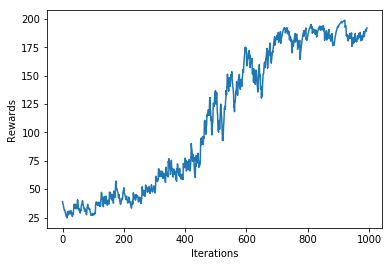

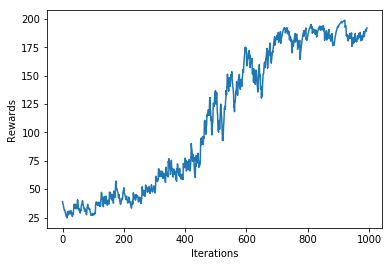

In [2]:
cartpole_model = create_cartpole_model()

smoothed_reward = util.LossHistory(smoothing_factor=0.9)
plotter = util.PeriodicPlotter(sec=5, xlabel='Iterations', ylabel='Rewards')


for i_episode in range(1000):

    plotter.plot(smoothed_reward.get())

    # Restart the environment
    observation = env.reset()

    while True:
        # using our observation, take an action
        action = choose_action(cartpole_model, observation)
        next_observation, reward, done, info = env.step(action)
        # add to memory
        memory.add_to_memory(observation, action, reward)

        # is the episode over? did you crash or do so well that you're done?
        if done:
            # determine total reward and keep a record of this
            total_reward = sum(memory.rewards)
            smoothed_reward.append( total_reward )

            # initiate training - remember we don't know anything about how the agent is doing until it's crashed!
            train_step(cartpole_model, 
                       optimizer, 
                       observations = np.vstack(memory.observations),
                       actions = np.array(memory.actions),
                       discounted_rewards = discount_rewards(memory.rewards)
                      )

            memory.clear()
            break
        # update our observatons
        observation = next_observation

## Video Demonstration

In [ ]:
def save_video_of_model(model, env_name, filename='agent.mp4'):  
    import skvideo.io
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(40, 30))
    display.start()

    env = gym.make(env_name)
    obs = env.reset()
    shape = env.render(mode='rgb_array').shape[0:2]

    out = skvideo.io.FFmpegWriter(filename)

    done = False
    while not done: 
        frame = env.render(mode='rgb_array')
        out.writeFrame(frame)

        action = model(tf.convert_to_tensor(obs.reshape((1,-1)), tf.float32)).numpy().argmax()
        obs, reward, done, info = env.step(action)
    out.close()
    print ("Successfully saved into {}!".format(filename))

In [6]:
save_video_of_model(cartpole_model, "CartPole-v0")

from IPython.display import HTML
import io, base64
video = io.open('./agent.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
<video controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
</video>'''.format(encoded.decode('ascii')))

Successfully saved into agent.mp4!


## Google Colab PyDrive

In [ ]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [7]:
# Create & upload a file.
uploaded = drive.CreateFile({'title': 'agent.mp4'})
uploaded.SetContentFile('agent.mp4')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 15l5G8qH7QgbD6vphFAXC0BwbEaJyVCeT


## Optional part (Pong)

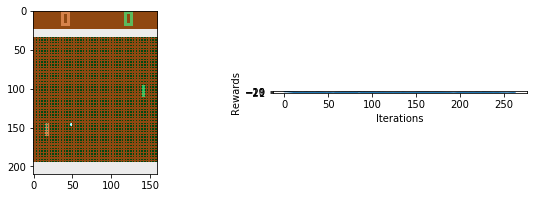

In [0]:
#Start of the optional part

env = gym.make("Pong-v0")
env.seed(1) # reproducible, since RL has high variance

print "Enviornment has observation space = {}".format(env.observation_space)

n_actions = env.action_space.n
print "Number of possible actions that the agent can choose from = {}".format(n_actions)

def create_pong_model():
    model = tf.keras.models.Sequential([
        # Define and reshape inputs
        tf.keras.layers.InputLayer(input_shape=(6400,), dtype=tf.float32),
        tf.keras.layers.Reshape((80, 80, 1)),

        # Convolutional layers
        tf.keras.layers.Conv2D(filters=16, kernel_size=(8,8), strides=(4,4), activation='relu', padding='same'),
        # TODO: define a convolutional layer with 32 4x4 filters and 2x2 stride, ReLu activation
        tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4), strides=(2,2), activation='relu', padding='same'),

        tf.keras.layers.Flatten(),

        # Fully connected layer and output
        tf.keras.layers.Dense(units=256, activation='relu'),
        # TODO: define the output dimension of the last Dense layer
        # Hint: think about that the space the agent needs to act in
        tf.keras.layers.Dense(units=n_actions, activation=None)
    ])
    return model

pong_model = create_pong_model()

def discount_rewards(rewards, gamma=0.99): 
    discounted_rewards = np.zeros_like(rewards)
    R = 0
    for t in reversed(range(0, len(rewards))):
        # NEW: Reset sum
        if rewards[t] != 0:
            R = 0
        # update the total discounted reward as before
        R = R * gamma + rewards[t]
        discounted_rewards[t] = R

    return normalize(discounted_rewards)

def pre_process(image):
    I = image[35:195] # Crop
    I = I[::2, ::2, 0] # Downsample width and height by a factor of 2
    I[I == 144] = 0 # Remove background type 1
    I[I == 109] = 0 # Remove background type 2
    I[I != 0] = 1 # Set remaining elements (paddles, ball, etc.) to 1
    return I.astype(np.float).ravel()

observation = env.reset()
for i in range(30):
    observation, _,_,_ = env.step(0)
observation_pp = pre_process(observation)

f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.imshow(observation); ax.grid('off');
ax2.imshow(observation_pp.reshape((80,80))); ax2.grid('off'); plt.title('Preprocessed Observation')

learning_rate=1e-4
optimizer = tf.train.AdamOptimizer(learning_rate)	

pong_model = create_pong_model()
MAX_ITERS = 10000

smoothed_reward = util.LossHistory(smoothing_factor=0.9)
plotter = util.PeriodicPlotter(sec=5, xlabel='Iterations', ylabel='Rewards')
memory = Memory()

for i_episode in range(MAX_ITERS):

    plotter.plot(smoothed_reward.get())

    # Restart the environment
    observation = env.reset()
    previous_frame = pre_process(observation)


    while True:
        # Pre-process image 
        current_frame = pre_process(observation)

        '''TODO: determine the observation change
      Hint: this is the difference between the past two frames'''
        obs_change = current_frame - previous_frame
        '''TODO: choose an action for the pong model, using the frame difference, and evaluate'''
        action = choose_action(pong_model, obs_change)

        # Take the chosen action
        next_observation, reward, done, info = env.step(action)
        '''TODO: save the observed frame difference, the action that was taken, and the resulting reward!'''
        memory.add_to_memory(obs_change, action, reward)

        # is the episode over? did you crash or do so well that you're done?
        if done:
            # determine total reward and keep a record of this
            total_reward = sum(memory.rewards)
            smoothed_reward.append( total_reward )

            # begin training
            train_step(pong_model, 
                       optimizer, 
                       observations = np.vstack(memory.observations), 
                       actions = np.array(memory.actions),
                       discounted_rewards = discount_rewards(memory.rewards))

            memory.clear()
            break

        observation = next_observation
        previous_frame = current_frame

save_video_of_model(pong_model, "Pong-v0", filename='pong_agent.mp4')  

from IPython.display import HTML
import io, base64
video = io.open('./pong_agent.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
<video controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
</video>'''.format(encoded.decode('ascii')))

In [0]:
# Create & upload a file.
uploaded = drive.CreateFile({'title': 'pong_agent.mp4'})
uploaded.SetContentFile('pong_agent.mp4')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))